In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


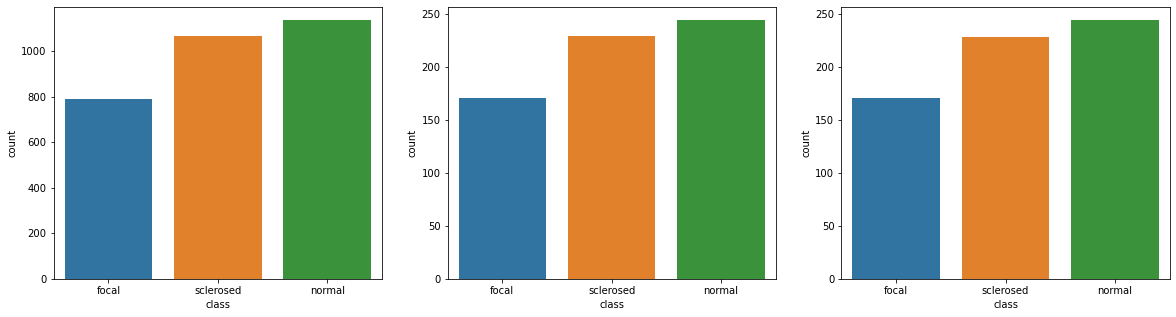

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
BUFFER_SIZE = len(train_folders)
IMG_SIZE = 512

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
test_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        shuffle=BUFFER_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  shuffle=BUFFER_SIZE,
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      shuffle=BUFFER_SIZE,
                                                      batch_size=BATCH_SIZE, 
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

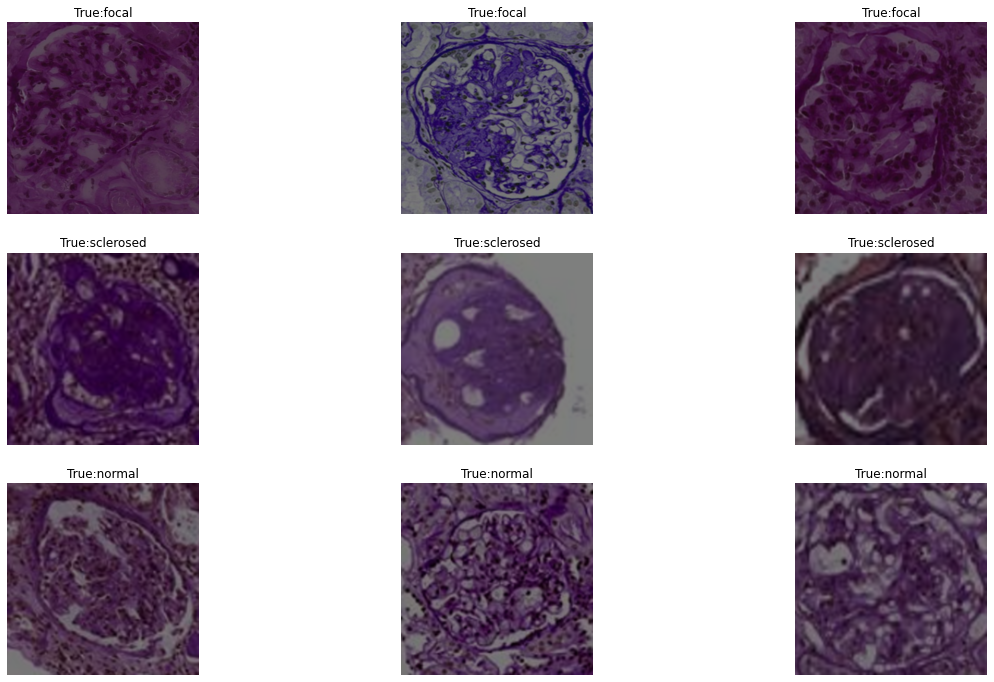

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.4280703067779541, 0.861586332321167]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
1497/1497 [==============================] - 91s 48ms/step - loss: 0.1415 - acc: 0.9462 - val_loss: 0.1627 - val_acc: 0.9502
Epoch 2/30
1497/1497 [==============================] - 73s 49ms/step - loss: 0.1260 - acc: 0.9539 - val_loss: 0.1657 - val_acc: 0.9424
Epoch 3/30
1497/1497 [==============================] - 73s 49ms/step - loss: 0.1263 - acc: 0.9522 - val_loss: 0.2039 - val_acc: 0.9252
Epoch 4/30
1497/1497 [==============================] - 73s 49ms/step - loss: 0.1231 - acc: 0.9516 - val_loss: 0.2574 - val_acc: 0.9019
Epoch 5/30
1497/1497 [==============================] - 74s 50ms/step - loss: 0.1225 - acc: 0.9569 - val_loss: 0.2187 - val_acc: 0.9299
Epoch 6/30
1497/1497 [==============================] - 79s 53ms/step - loss: 0.1288 - acc: 0.9512 - val_loss: 0.2108 - val_acc: 0.9190
Epoch 7/30
1497/1497 [==============================] - 72s 48ms/step - loss: 0.1214 - acc: 0.9552 - 

[0.23569731414318085, 0.9082425832748413]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(4)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
749/749 [==============================] - 90s 65ms/step - loss: 0.0763 - acc: 0.9709 - val_loss: 0.1584 - val_acc: 0.9548
Epoch 2/30
749/749 [==============================] - 49s 65ms/step - loss: 0.0751 - acc: 0.9696 - val_loss: 0.2368 - val_acc: 0.9237
Epoch 3/30
749/749 [==============================] - 49s 65ms/step - loss: 0.0794 - acc: 0.9699 - val_loss: 0.1641 - val_acc: 0.9502
Epoch 4/30
749/749 [==============================] - 50s 66ms/step - loss: 0.0790 - acc: 0.9689 - val_loss: 0.1631 - val_acc: 0.9564
Epoch 5/30
749/749 [==============================] - 51s 67ms/step - loss: 0.0747 - acc: 0.9726 - val_loss: 0.1696 - val_acc: 0.9533
Epoch 6/30
749/749 [==============================] - 49s 66ms/step - loss: 0.0813 - acc: 0.9696 - val_loss: 0.1649 - val_acc: 0.9502
Epoch 7/30
749/749 [==============================] - 50s 66ms/step - loss: 0.0725 - acc: 0.9736 - val_loss: 0.19

[0.22548845410346985, 0.9284603595733643]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(8)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
375/375 [==============================] - 83s 101ms/step - loss: 0.0496 - acc: 0.9823 - val_loss: 0.2661 - val_acc: 0.9486
Epoch 2/30
375/375 [==============================] - 41s 107ms/step - loss: 0.0463 - acc: 0.9850 - val_loss: 0.1714 - val_acc: 0.9517
Epoch 3/30
375/375 [==============================] - 43s 114ms/step - loss: 0.0481 - acc: 0.9836 - val_loss: 0.1990 - val_acc: 0.9533
Epoch 4/30
375/375 [==============================] - 44s 115ms/step - loss: 0.0472 - acc: 0.9816 - val_loss: 0.1760 - val_acc: 0.9611
Epoch 5/30
375/375 [==============================] - 44s 116ms/step - loss: 0.0494 - acc: 0.9800 - val_loss: 0.2268 - val_acc: 0.9455
Epoch 6/30
375/375 [==============================] - 44s 116ms/step - loss: 0.0537 - acc: 0.9810 - val_loss: 0.1733 - val_acc: 0.9517
Epoch 7/30
375/375 [==============================] - 45s 118ms/step - loss: 0.0484 - acc: 0.9813 - val_los

[0.18706028163433075, 0.9517884850502014]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(16)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.2137833684682846, 0.9377915859222412]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(32)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.24863015115261078, 0.917573869228363]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(64)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
47/47 [==============================] - 79s 1s/step - loss: 0.2244 - acc: 0.9322 - val_loss: 0.2332 - val_acc: 0.9206
Epoch 2/30
47/47 [==============================] - 25s 508ms/step - loss: 0.2238 - acc: 0.9258 - val_loss: 0.2293 - val_acc: 0.9252
Epoch 3/30
47/47 [==============================] - 29s 605ms/step - loss: 0.2170 - acc: 0.9318 - val_loss: 0.2460 - val_acc: 0.9206
Epoch 4/30
47/47 [==============================] - 30s 623ms/step - loss: 0.2185 - acc: 0.9245 - val_loss: 0.2320 - val_acc: 0.9206
Epoch 5/30
47/47 [==============================] - 30s 625ms/step - loss: 0.2153 - acc: 0.9292 - val_loss: 0.2399 - val_acc: 0.9097
Epoch 6/30
47/47 [==============================] - 30s 616ms/step - loss: 0.2072 - acc: 0.9302 - val_loss: 0.2379 - val_acc: 0.9299
Epoch 7/30
47/47 [==============================] - 33s 689ms/step - loss: 0.2083 - acc: 0.9328 - val_loss: 0.2270 - val_a

[0.20662842690944672, 0.9300155639648438]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(128)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.3741072416305542, 0.8460342288017273]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(256)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30


ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[128,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan/ReadVariableOp_1/_64]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[128,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[128,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/_87]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function


In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(512)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30


ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[256,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan/ReadVariableOp_1/_64]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[256,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[256,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/AddN_1/_84]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function


In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1024)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[512,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/ReadVariableOp_2/_74]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[512,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[512,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/AddN_1/_84]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function


In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=20,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2048)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30


ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[472,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan/ReadVariableOp_1/_64]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[472,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[472,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node replica_1/model/block1_conv1/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan_1/AddN_1/_84]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function
